In [1]:
#Importando as libs

#bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Criando datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(13730, 167)

In [7]:
train.head(2)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A


In [8]:
train.describe()

,Unnamed: 0,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,CO_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,...,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,CO_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,CO_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041
count,13730.000000,13730.0,1.373000e+04,13730.000000,13730.000000,13202.000000,13730.000000,13730.000000,1.312100e+04,13121.000000,13730.000000,13730.000000,13730.000000,4282.000000,13730.000000,4.282000e+03,4.282000e+03,4282.000000,4282.000000,4282.000000,4282.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.0,13730.000000,...,13730.0,13730.000000,13730.0,13730.0,13730.0,13730.000000,13730.000000,1638.000000,1.373000e+04,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,10133.000000,13730.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,13730.000000,6355.000000,6355.000000,6354.000000,6354.000000,6354.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,2938.000000
mean,2288.173926,2016.0,3.088548e+06,30.736708,21.593809,0.116043,2.185652,1.048871,3.057946e+06,30.429159,1.782666,2.146176,1.353532,1.178888,0.129862,3.121720e+07,3.123638e+06,31.085474,2.259692,1.030827,1.001635,0.001238,0.0,0.000364,0.000510,0.0,0.002185,0.000146,0.000947,0.000073,0.000073,0.0,0.000437,0.000510,0.009687,0.000947,0.001602,0.000146,0.0,0.004151,...,0.0,0.000073,0.0,0.0,0.0,0.000364,0.119301,30.639194,3.085637e+06,30.709250,0.754479,0.754479,0.738747,0.738747,473.495155,529.661087,516.472841,482.497928,0.593664,1.101747,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258,4.083467,3.833360,2.608812,4.375984,4.530217,3.962858,4.645594,4.678441,3.341515,4.458995,3.724618,3.506409,4.442098,3.671545
std,1321.230607,0.0,9.890495e+05,9.862405,7.043654,0.365986,1.007285,0.258895,9.703020e+05,9.670030,0.880734,3.217328,0.558472,0.565490,0.336163,9.540289e+06,9.574114e+05,9.546193,0.698586,0.172868,0.040404,0.035167,0.0,0.019080,0.022575,0.0,0.046695,0.012069,0.030757,0.008534,0.008534,0.0,0.020901,0.022575,0.097947,0.030757,0.039998,0.012069,0.0,0.064301,...,0.0,0.008534,0.0,0.0,0.0,0.019080,0.324154,9.884543,9.888721e+05,9.860227,0.431932,0.431932,0.440162,0.440162,71.093674,73.726344,68.688190,99.826323,0.491167,0.700100,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758,1.603004,1.661301,2.234009,1.210998,1.027613,1.625356,0.920998,0.865039,1.711930,1.200172,1.689362,1.718858,1.181549,1.746444
min,0.000000,2016.0,1.100023e+06,11.000000,13.000000,0.000000,0.000000,0.000000,1.100023e+06,11.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.100189e+07,1.100023e+06,11.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,11.000000,1.100023e+06,11.000000,0.000000,0.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Columns: 167 entries, Unnamed: 0 to Q050
dtypes: float64(28), int64(79), object(60)
memory usage: 17.5+ MB


In [11]:
train.isna().sum().sort_values(ascending=False) # nulos

CO_UF_ENTIDADE_CERTIFICACAO    12092
NO_ENTIDADE_CERTIFICACAO       12092
SG_UF_ENTIDADE_CERTIFICACAO    12092
Q041                           10792
TP_SIT_FUNC_ESC                 9448
                               ...  
Q002                               0
Q003                               0
Q004                               0
Q005                               0
Unnamed: 0                         0
Length: 167, dtype: int64

In [12]:
train.isna().sum().sum() # valor total de nulos

253786

In [13]:
#verificando se os datasets possuem as mesmas classes de entrada
comparar = train
comparar = comparar.drop('NU_NOTA_MT',axis=1) #o dataset test não tem essa coluna, por isso ela é removida
verifica = set(comparar.columns).issubset(set(test.columns))
if verifica:
    print('Ambos os datasets POSSUEM as mesmas colunas - Saida:', verifica)
else:
    print('Ambos os datasets NÃO POSSUEM as mesmas colunas - Saida:', verifica)

Ambos os datasets NÃO POSSUEM as mesmas colunas - Saida: False


In [18]:
#verificação de quais features o dataset test possue.

print('FEATURES DO DATASET (test):')
print()
colunas = test.columns
leng,step = len(colunas)-3,3
for i in range(0,leng,step):  
    print(colunas[i],'|',colunas[i+1],'|',colunas[i+2])

FEATURES DO DATASET (test):

NU_INSCRICAO | CO_UF_RESIDENCIA | SG_UF_RESIDENCIA
NU_IDADE | TP_SEXO | TP_COR_RACA
TP_NACIONALIDADE | TP_ST_CONCLUSAO | TP_ANO_CONCLUIU
TP_ESCOLA | TP_ENSINO | IN_TREINEIRO
TP_DEPENDENCIA_ADM_ESC | IN_BAIXA_VISAO | IN_CEGUEIRA
IN_SURDEZ | IN_DISLEXIA | IN_DISCALCULIA
IN_SABATISTA | IN_GESTANTE | IN_IDOSO
TP_PRESENCA_CN | TP_PRESENCA_CH | TP_PRESENCA_LC
CO_PROVA_CN | CO_PROVA_CH | CO_PROVA_LC
CO_PROVA_MT | NU_NOTA_CN | NU_NOTA_CH
NU_NOTA_LC | TP_LINGUA | TP_STATUS_REDACAO
NU_NOTA_COMP1 | NU_NOTA_COMP2 | NU_NOTA_COMP3
NU_NOTA_COMP4 | NU_NOTA_COMP5 | NU_NOTA_REDACAO
Q001 | Q002 | Q006
Q024 | Q025 | Q026


In [19]:
#Qual nota de competencia tem melhor correlação com a nota de matematica?

var = ['NU_NOTA_MT','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5']
train[var].corr()

,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
NU_NOTA_MT,1.000000,0.299402,0.335638,0.350307,0.342282,0.343337
NU_NOTA_COMP1,0.299402,1.000000,0.756664,0.759452,0.824538,0.558587
NU_NOTA_COMP2,0.335638,0.756664,1.000000,0.875447,0.808006,0.655915
NU_NOTA_COMP3,0.350307,0.759452,0.875447,1.000000,0.827151,0.664350
NU_NOTA_COMP4,0.342282,0.824538,0.808006,0.827151,1.000000,0.635018
NU_NOTA_COMP5,0.343337,0.558587,0.655915,0.664350,0.635018,1.000000


A melhor correlação foi com a feature ['NU_NOTA_COMP3'], conforme a tabela de correlação.


In [22]:
# Criando dataset com as features necessárias para o problema
train_new = {
    'mat': train['NU_NOTA_MT'],
    'cien_n': train['NU_NOTA_CN'],
    'ling_c': train['NU_NOTA_LC'],
    'cien_h': train['NU_NOTA_CH'],
    'redacao': train['NU_NOTA_REDACAO'],
    'nota_comp3': train['NU_NOTA_COMP3']
}

In [23]:
#Substituindo o dataset train antigo

train = pd.DataFrame(train_new)

In [24]:
#Removendo elementos com dados faltantes
train = train.dropna(axis=0, how='any')

In [28]:
train.isna().sum()

mat           0
cien_n        0
ling_c        0
cien_h        0
redacao       0
nota_comp3    0
dtype: int64

In [26]:
train.head(2)

,mat,cien_n,ling_c,cien_h,redacao,nota_comp3
0,399.4,436.3,581.2,495.4,520.0,120.0
1,459.8,474.5,599.0,544.1,580.0,120.0


In [44]:
# Função 1 - Criação uma nova coluna com a media das notas

def media(nota1,nota2,nota3,nota4,nota5):
    total_media = []
    for i in range(len(nota1)):
        result = nota1[i]+nota2[i]+nota3[i]+nota4[i]+nota5[i]/5
        total_media.append(result)
    return total_media

# Função 2 - Plotar grafico para comparação


def grafico(previsao,real,nome):
    previsao = np.array(previsao)
    real = np.array(real)
    
    erro_mae = mean_absolute_error(real,previsao)
    
    y1 = previsao[:50]
    x1 = range(len(y1))
    y2 = real[:50]
    x2 = range(len(y2))
    

    plt.title('Gráfico de Predições:' + nome)
    plt.xlabel('Média percentual do desvio absoluto (MAPE): ' + str(erro_mae))
    plt.ylabel('Valores')

    plt.plot(x1,y1,color='#51b521',linestyle='--',label='Predita')
    plt.plot(x2,y2,color='#222325',linestyle='-.', label = 'Esperada')
    plt.legend()
    plt.show()

#Função 3 - Reduzir escala dos dados
def reducao_on(train):
    train = train /100
    return train

#Função 4 - Retornar os dados que foram reduzidos
def reducao_off(train):
    train = train*100
    return train

#Definindo função para plotar grafico de comparação
def grafico_mape(xy1,xy2,xy3,title):
    plt.suptitle('Média percentual do desvio absoluto (MAPE)')
    plt.title(title)
    plt.ylabel('MAPE')
    plt.xlabel('Menor erro = Melhor desempenho')

    plt.bar(xy1[0],xy1[1])
    plt.bar(xy2[0],xy2[1])
    plt.bar(xy3[0],xy3[1])
    plt.show()

tst_size = 0.10

In [41]:
#Criar coluna media
train['media'] = media(np.array(train.mat),np.array(train.cien_n),np.array(train.ling_c),np.array(train.cien_h),np.array(train.redacao))
train.head()

,mat,cien_n,ling_c,cien_h,redacao,nota_comp3,media
0,399.4,436.3,581.2,495.4,520.0,120.0,2016.3
1,459.8,474.5,599.0,544.1,580.0,120.0,2193.4
5,364.5,439.7,410.9,583.2,620.0,120.0,1922.3
6,529.2,420.1,484.5,604.2,560.0,120.0,2150.0
7,566.7,619.6,611.2,625.8,620.0,120.0,2547.3


In [42]:
# Para tentar melhorar a eficácia, vou reduzir a escala dos dados a mesma proporção. Os valores foram divididos por 100.

train_reducao = train #colocando o dataset em outra variável afim de evitar sobrecarga


In [43]:
#celulas separas para evitar sobrecarga
train = reducao_on(train_reducao)
train.head()

,mat,cien_n,ling_c,cien_h,redacao,nota_comp3,media
0,3.994,4.363,5.812,4.954,5.2,1.2,20.163
1,4.598,4.745,5.990,5.441,5.8,1.2,21.934
5,3.645,4.397,4.109,5.832,6.2,1.2,19.223
6,5.292,4.201,4.845,6.042,5.6,1.2,21.500
7,5.667,6.196,6.112,6.258,6.2,1.2,25.473


##Modelos de Treinamento

###Regressão Linear

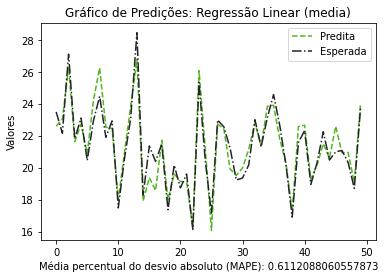

In [48]:
#Separando as variaveis independentes e dependente
y = train['media']
X = train
X = X.drop(['mat','media'],axis=1)

#split das bases
X_train, X_test , y_train, y_test = train_test_split(X , y, test_size=tst_size)

#treinando media, sem as notas de matematica
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
prever = reg_lin.predict(X_test)
RL_media = ['LinearRegression: ',mean_absolute_error(y_test, prever)]

#imprimindo predições
grafico(prever, y_test,' Regressão Linear (media)')

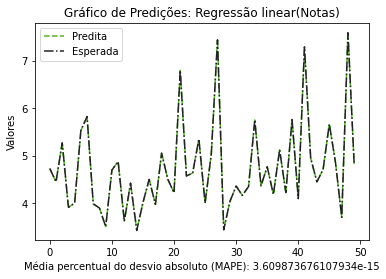

In [52]:
#separando dados de entrada(x) e saida(y)
y = train['mat']
X = train

X = X.drop(['mat'],axis=1)

#split de dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tst_size)

#treinando notas de matematica, sem os dados de media
reg_lin2 = LinearRegression()
reg_lin2.fit(X_train,y_train)
prever = reg_lin2.predict(X_test)
RL_nota = ['LinearRegression',mean_absolute_error(y_test,prever)]

#plotando predições
grafico(prever, y_test,' Regressão linear(Notas)')

###KNN (K-Nearest Neighbors)

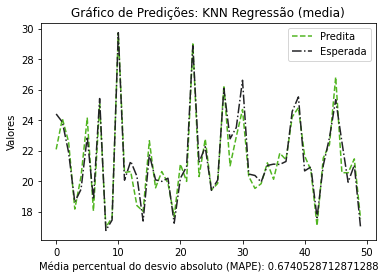

In [59]:
#Separando as variaveis independentes e dependente
y = train['media']
X = train
X = X.drop(['mat','media'], axis=1)

#split das bases
X_train, X_test , y_train, y_test = train_test_split(X , y, test_size=tst_size)

#treinando media knn, sem as notas de matematica
knn = KNeighborsRegressor(n_neighbors = 5, p=1)
knn.fit(X_train, y_train)
prever = knn.predict(X_test)
KNN_media = [' KNN: ', mean_absolute_error(y_test, prever)]

#imprimindo predições
grafico(prever, y_test, ' KNN Regressão (media)')

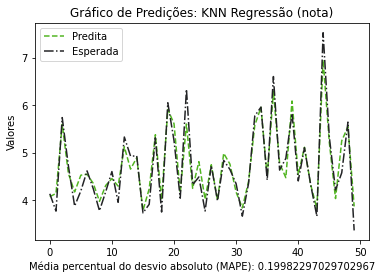

In [60]:
#Separando as variaveis independentes e dependente
y = train['mat']
X = train
X = X.drop(['mat'], axis=1)

#split das bases
X_train, X_test , y_train, y_test = train_test_split(X , y, test_size=tst_size)

#treinando media knn, sem as notas de matematica
knn2 = KNeighborsRegressor(n_neighbors = 5, p=1)
knn2.fit(X_train, y_train)
prever = knn2.predict(X_test)
KNN_nota = [' KNN: ', mean_absolute_error(y_test, prever)]

#imprimindo predições
grafico(prever, y_test, ' KNN Regressão (nota)')

###Random Forest

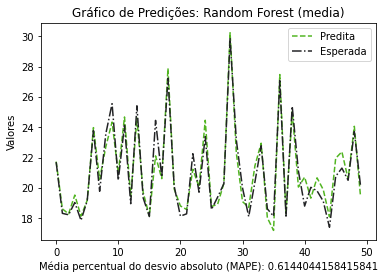

In [61]:
#Separando as variaveis independentes e dependente
y = train['media']
X = train
X = X.drop(['mat','media'], axis=1)

#split das bases
X_train, X_test , y_train, y_test = train_test_split(X , y, test_size=tst_size)

#treinando media RF, sem as notas de matematica
RF = RandomForestRegressor(n_estimators=50)
RF.fit(X_train, y_train)
prever = RF.predict(X_test)
RF_media = [' Random Forest: ', mean_absolute_error(y_test, prever)]

#imprimindo predições
grafico(prever, y_test, ' Random Forest (media)')

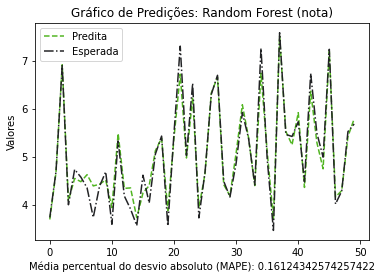

In [62]:
#Separando as variaveis independentes e dependente
y = train['mat']
X = train
X = X.drop(['mat'], axis=1)

#split das bases
X_train, X_test , y_train, y_test = train_test_split(X , y, test_size=tst_size)

#treinando media RF, sem as notas de matematica
RF2 = RandomForestRegressor(n_estimators=50)
RF2.fit(X_train, y_train)
prever = RF2.predict(X_test)
RF_nota = [' Random Forest: ', mean_absolute_error(y_test, prever)]

#imprimindo predições
grafico(prever, y_test, ' Random Forest (nota)')

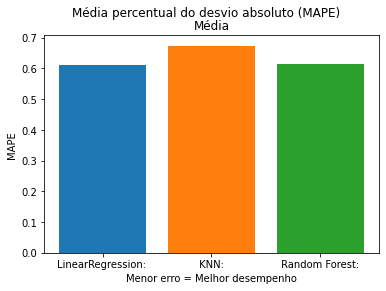

In [64]:
grafico_mape(RL_media,KNN_media,RF_media,'Média')

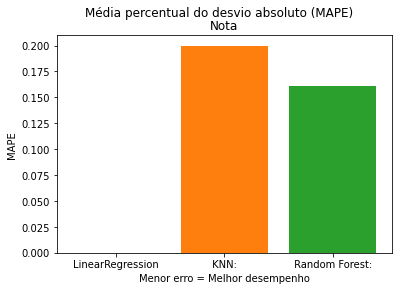

In [65]:
grafico_mape(RL_nota,KNN_nota,RF_nota,'Nota')

A **LinearRegression** teve erro muito elevado em comparado aos demais modelos, por isso ele não foi exibido no plot.

In [69]:
# preparando a base de teste
test_new = {
    'cien_n': test['NU_NOTA_CN'],
    'ling_c': test['NU_NOTA_LC'],
    'cien_h': test['NU_NOTA_CH'],
    'redacao': test['NU_NOTA_REDACAO'],
    'nota_comp3': test['NU_NOTA_COMP3']
}

In [86]:
dados = pd.DataFrame(test_new)

In [87]:
dados = dados.dropna(axis=0, how='any') # removendo os nulos

In [88]:
# normalizando dados
dados = normalize_on(dados)

In [89]:
dados.head()

,cien_n,ling_c,cien_h,redacao,nota_comp3
0,4.648,4.318,4.435,4.2,0.8
1,3.911,5.480,4.911,5.8,1.2
2,5.959,6.136,6.227,3.2,0.4
4,5.929,5.714,4.926,3.2,0.6
5,4.145,5.425,5.685,5.6,1.2


In [90]:
#Predições de média para o dataset de respostas
respostas = RF.predict(dados)
dados['media'] = respostas
dados.head(1)

,cien_n,ling_c,cien_h,redacao,nota_comp3,media
0,4.648,4.318,4.435,4.2,0.8,18.50342


In [91]:
#Predições de notas de matemática
respostas = RF2.predict(dados)
dados['mat'] = respostas
dados.head()

,cien_n,ling_c,cien_h,redacao,nota_comp3,media,mat
0,4.648,4.318,4.435,4.2,0.8,18.50342,4.10960
1,3.911,5.480,4.911,5.8,1.2,19.93556,4.34740
2,5.959,6.136,6.227,3.2,0.4,25.43474,6.14972
4,5.929,5.714,4.926,3.2,0.6,22.66324,5.26176
5,4.145,5.425,5.685,5.6,1.2,21.00412,4.68642


In [92]:
#Removendo as normalização da coluna de matemática

dados['mat'] = normalize_off(dados['mat'])
dados.head()

,cien_n,ling_c,cien_h,redacao,nota_comp3,media,mat
0,4.648,4.318,4.435,4.2,0.8,18.50342,410.960
1,3.911,5.480,4.911,5.8,1.2,19.93556,434.740
2,5.959,6.136,6.227,3.2,0.4,25.43474,614.972
4,5.929,5.714,4.926,3.2,0.6,22.66324,526.176
5,4.145,5.425,5.685,5.6,1.2,21.00412,468.642


In [93]:
#Finalizando o tratamento dos dados
dados = dados.drop(['cien_n','ling_c','cien_h','redacao','nota_comp3'],axis=1)
dados['NU_INSCRICAO'] =  test['NU_INSCRICAO']
dados['NU_NOTA_MT'] = dados['mat']
dados = dados.drop(['mat'],axis=1)
dados = dados.drop(['media'],axis=1)
dados['NU_NOTA_MT'] = dados['NU_NOTA_MT']

In [94]:
dados.to_csv('answer.csv',index=False) #criando CSV

In [95]:
nota_final = pd.read_csv('answer.csv')
nota_final.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,410.960
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,434.740
2,b38a03232f43b11c9d0788abaf060f7366053b6d,614.972
3,715494628a50142ce8cb17191cfe6d0f3cae0934,526.176
4,e656d6bad65c93fb2880f1eba5037008c8e75774,468.642
